In [1]:
%load_ext autoreload
%autoreload 2

# fundamentals
import os, sys
import numpy as np
import pandas as pd
from calendar import monthrange, month_name
import scipy.stats as stats
import datetime
import imp
import scipy.io as sio
import pickle as pkl

# plotting libraries and setup
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
plt.style.use('nrelplot')
from windrose import WindroseAxes

# met mast functions and utilities
sys.path.append('../')
import met_funcs as MET
import vis as vis
import utils as utils

In [2]:
###########################################
def rose_fig(metdat, varcol, dircol, bins=6, nsector=36, ylim=None, noleg=False):
    ###########################################
    """
    make wind rose from pandas.Series wind direction and some other value of the same size.
    Parameters:
        metdat:
            Pandas dataframe containing met mast data
        catinfo:
            dict containing categorization info for the metmast data. Fore each category,
            catinfo holds column names, labels, units, and save names
        category:
            string specifying category of information to plot (e.g. 'speed', 'stability', etc.)
        vertloc:
            int or float describing the exact or approximate height of interest along the tower
        bins:
            int specifying number of equally spaced bins to divide var.
            OR
            list of bin division limits (eg [0,4,8,12,16])
        nsector:
            number or direction sectors to divide rose
        ylim:
            optional float with maximum value for frequency of observations, use to
            plot different roses with uniform limits
        noleg:
            bool switch to turn legend off
    """

    # set up data
    winddir = metdat[dircol]
    var = metdat[varcol]

    relabel = False
    if not isinstance(bins, int):
        if ((bins < 0).any()):
            bins *= -1
            relabel = True
        
    # get var divisions set up
    if isinstance(bins, int):
        nbins = bins
    else:
        nbins = len(bins)

    # set up plotting colors
    colors = utils.get_colors(nbins-1, basecolor='span')
    colors += ['#3A4246'] # add something dark to the end.
    colors = tuple(colors[0:nbins])

    # built figure
    fig = plt.figure()
    ax = WindroseAxes.from_ax(fig=fig)
    ax.bar(winddir, var, normed=True, opening=0.95, edgecolor='white', bins=bins, nsector=nsector, colors=colors, linewidth=0.35)

    # legend
    leg=['blank']
    if noleg is not True:
        leg = ax.set_legend(loc=6,bbox_to_anchor=(1.25,0.5), fontsize=10, frameon=False)
        
        if relabel:
            for ii in range(nbins-1):
                leg.get_texts()[ii].set_text('[{}: {})'.format(-bins[ii], -bins[ii+1]))
            leg.get_texts()[-1].set_text('[{}: {})'.format(-bins[-1], '-inf'))

    # adjust plot for specified max frequency
    if ylim is None:
        ylim = ax.get_ylim()[-1]

    # frequency axis limits and labels
    ax.set_ylim(0,ylim)
    ax.set_yticks(np.linspace(0,ylim,4))
    ax.set_yticklabels([str(round(x,1)) for x in np.linspace(0,ylim,4)])


    return fig, ax, leg
###########################################

def extreme_event_hist(eventdf, varcols, labels, bins=25, colors=None, alpha=1):
    '''
    
    '''
    
    fig, ax = plt.subplots(figsize=(5,3))

    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]

    for ii, var in enumerate(varcols):
        data = eventdf[var].dropna(how='any')


        n,histbins,patches = ax.hist(data,
                                    bins = bins,
                                    facecolor=colors[ii],
                                    edgecolor='k',
                                    weights=100*np.ones(data.shape) / len(data), 
                                    density=False,
                                    label=labels[ii], alpha=alpha)
    leg = ax.legend(frameon=False)
    ax.set_ylabel('Frequency [\%]')
    
    return fig, ax, leg

def extreme_event_wind_direction_bar(eventdf, varcols, labels, colors=None):
    '''
    
    '''
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]
        
    event_bydir = eventdf.groupby('dirbin').count()
    tmp = event_bydir[varcols].copy()
    tmp = 100*tmp.div(tmp.sum())

    fig, ax = plt.subplots(figsize=(8,3))
    
    tmp.plot.bar(ax=ax, color=colors[:len(varcols)], width=0.9, edgecolor='k')
    leg  = ax.legend(labels)
    xlabs = ax.get_xticklabels()[::2]
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xticklabels(xlabs)
    ax.set_xlabel('Wind Direction [$^\circ$]')
    ax.set_ylabel('Frequency [\%]')

    return fig, ax, leg

# fig.savefig('../figs_20190109/alpha_bar.pdf')

def extreme_event_monthly_bar(eventdf, varcols, labels, colors=None):
    '''
    
    '''
    
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]

    numyears = eventDF.index.year.max() - eventDF.index.year.min()
    monthly = eventdf[varcols].groupby(eventdf.index.month).count()/numyears
#     monthly = monthly.div(monthly.sum())*100

    fig, ax = plt.subplots(figsize=(5,3))
    monthly.plot.bar(ax=ax, label=labels, color=colors[:len(varcols)])
    ax.set_xlabel('Month')
    ax.set_ylabel('Events Per Month')
    leg = ax.legend(labels, frameon=False)

    return fig, ax, leg 


def extreme_event_velocity_scatter(eventdf, varcols, labels, colors=None, ):
    '''
    
    '''
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]
    
    fig, ax = plt.subplots(figsize=(5,3))

    for ii, var in enumerate(varcols):
        eventdf.plot.scatter('WS_mean', var, ax=ax, edgecolor=colors[ii], color='w', label=labels[ii])

    ax.set_xlabel('Hub-Height Velocity [m/s]')
    ax.legend(frameon=False)

    return fig, ax, leg 

## Data directory and list of files containing extreme events

In [3]:
datapath = '/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/IEC_tmp/'
monthly_events_files = os.listdir(datapath)
today = datetime.date.today()
figpath = '../figs_{}{}{}'.format(str(today.year), str(today.month).zfill(2), str(today.day).zfill(2))
params = MET.setup_IEC_params()
try:
    os.makedirs(figpath)
except:
    pass

### Extreme Shear Events

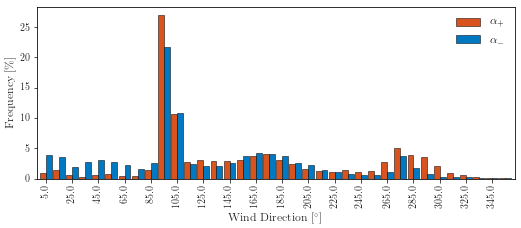

In [159]:
event_type = 'EWS'
events_files = [x for x in monthly_events_files if event_type in x]

eventDF = pd.DataFrame()
for file in events_files:
    tmp = pd.read_csv(os.path.join(datapath, file))
    eventDF = pd.concat([eventDF, tmp])
eventDF.set_index('datetime', inplace=True)
eventDF.index = pd.DatetimeIndex(eventDF.index)


eventDF['alpha_min'][eventDF['alpha_min'] > eventDF['alpha_neg_limit']] = np.nan
eventDF['alpha_min'][np.abs(eventDF['alpha_min']) > 10.0] = np.nan

eventDF['alpha_max'][eventDF['alpha_max'] < eventDF['alpha_pos_limit']] = np.nan
eventDF['alpha_max'][np.abs(eventDF['alpha_max']) > 10.0] = np.nan

binwidth = 10
eventDF['dirbin'] = pd.cut(eventDF['WD_mean'], bins=np.arange(0,360.1, binwidth), labels=np.arange(binwidth/2,360.1, binwidth))

varcols = ['alpha_max', 'alpha_min']
labels = [r'$\alpha_+$', r'$\alpha_-$']

# ## Rose figures
# fig, ax, leg = rose_fig(eventDF, 'alpha_max', 'dirbin', bins=np.array([0,0.5,1,1.5,2,2.5]))
# leg.set_title(r'$\alpha_+$')
# fig.savefig('{}/{}_pos_rose.pdf'.format(figpath, event_type))

# tmp = eventDF[['dirbin','alpha_min']].copy()
# tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna(how='any')
# tmp['alpha_min'] *= -1

# fig, ax, leg = rose_fig(tmp, 'alpha_min', 'dirbin', bins=-np.array([0,0.5,1,1.5,2,2.5]))
# leg.set_title(r'$\alpha_-$')
# fig.savefig('{}/{}_neg_rose.pdf'.format(figpath, event_type))


## Wind dir bar plot
fig, ax, leg = extreme_event_wind_direction_bar(eventDF, varcols, labels)
fig.savefig('{}/{}_bar.pdf'.format(figpath, event_type))


# ## monthly frequency bar plot
# fig, ax, leg  = extreme_event_monthly_bar(eventDF, varcols, labels)
# fig.savefig('{}/{}_monthly.pdf'.format(figpath, event_type))


# ## Velocity scatter plot
# # adding some limitting lines here
# params = MET.setup_IEC_params()
# alpha_pos = np.load('/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/pos_alpha_limit.npy')
# alpha_neg = np.load('/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/neg_alpha_limit.npy')
# alpha_reference_velocity = np.load('/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/alpha_reference_velocity.npy')

# fig, ax, leg  = extreme_event_velocity_scatter(eventDF, varcols, labels)
# ax.plot(alpha_reference_velocity, alpha_pos, 'k')
# ax.plot(alpha_reference_velocity, alpha_neg, 'k')
# ax.set_ylabel('Shear Exponent [-]')
# fig.savefig('{}/{}_v_limits.pdf'.format(figpath, event_type))


# ## Histogram
# fig, ax, leg  = extreme_event_hist(eventDF, varcols, labels)
# ax.set_xlabel('Shear Exponent [-]')
# fig.savefig('{}/{}_hist.pdf'.format(figpath, event_type))

### Extreme Operating Gust Events

In [8]:
eventDF.head(1)

,WS_min,WD_min,WS_max,WD_max,WS_mean,WD_mean,WS_pos_gustlim,WS_neg_gustlim,dirbin
datetime,,,,,,,,,
2016-09-08 19:50:00,7.094683,137.027031,8.010387,151.678502,4.744203,142.403468,7.749952,3.656993,145.0


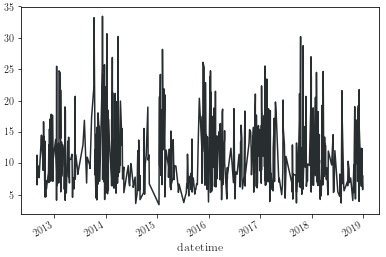

In [10]:
eventDF.WS_max.plot()

In [17]:
figpath

'../figs_20190118'

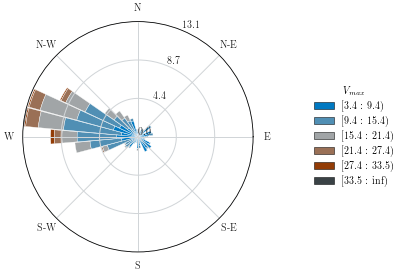

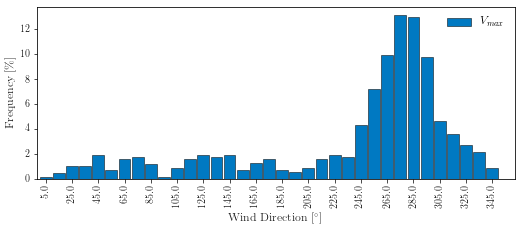

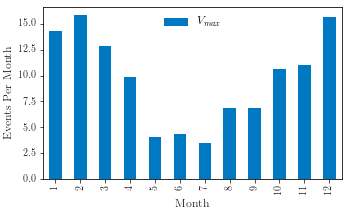

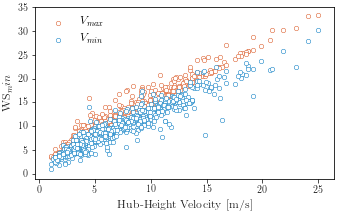

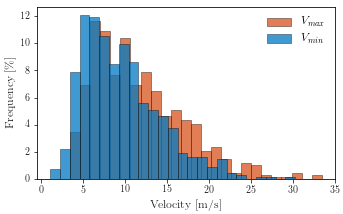

In [26]:
event_type = 'EOG'
events_files = [x for x in monthly_events_files if event_type in x]

eventDF = pd.DataFrame()
for file in events_files:
    tmp = pd.read_csv(os.path.join(datapath, file))
    eventDF = pd.concat([eventDF, tmp])
eventDF.rename(index=str, columns={'Unnamed: 0': 'datetime'}, inplace=True)
eventDF.set_index('datetime', inplace=True)
eventDF.index = pd.DatetimeIndex(eventDF.index)


binwidth = 10
eventDF['dirbin'] = pd.cut(eventDF['WD_mean'], bins=np.arange(0,360.1, binwidth), labels=np.arange(binwidth/2,360.1, binwidth))

varcols = ['WS_max', 'WS_min']
labels = [r'$V_{max}$', r'$V_{min}$']


# ## Rose figures
fig, ax, leg = rose_fig(eventDF, varcols[0], 'dirbin', bins=6)
leg.set_title(labels[0])
fig.savefig('{}/{}_{}_rose.pdf'.format(figpath, event_type, varcols[0]))

# fig, ax, leg = rose_fig(eventDF, varcols[1], 'dirbin', bins=6)
# leg.set_title(labels[1])
# fig.savefig('{}/{}_{}_rose.pdf'.format(figpath, event_type, varcols[1]))


# Wind dir bar plot
fig, ax, leg = extreme_event_wind_direction_bar(eventDF, varcols[0], labels, colors='C1')
fig.savefig('{}/{}_bar.pdf'.format(figpath, event_type))


# ## monthly frequency bar plot
fig, ax, leg  = extreme_event_monthly_bar(eventDF, varcols[0],'tmp', colors='C1')
leg = ax.legend(labels, frameon=False)
# ax.set_ylabel('Average ')
fig.savefig('{}/{}_monthly.pdf'.format(figpath, event_type))

# velocity scatter
fig,ax,leg = extreme_event_velocity_scatter(eventDF, varcols, labels)


## Histogram
fig, ax, leg  = extreme_event_hist(eventDF, varcols, labels, alpha=0.75)
ax.set_xlabel('Velocity [m/s]')
# ax.set_xlim()
fig.savefig('{}/{}_hist.pdf'.format(figpath, event_type))

In [25]:
tmp = eventDF.groupby(eventDF.index.year).count()
tmp.mean()

WS_min            99.142857
WD_min            99.142857
WS_max            99.142857
WD_max            99.142857
WS_mean           99.142857
WD_mean           99.142857
WS_pos_gustlim    99.142857
WS_neg_gustlim    99.142857
dirbin            99.142857
Vamp              99.142857
dtype: float64

In [16]:
eventDF['Vamp'] = eventDF['WS_max'] - eventDF['WS_mean']
eventDF[eventDF['Vamp'] == eventDF['Vamp'].max()]

,WS_min,WD_min,WS_max,WD_max,WS_mean,WD_mean,WS_pos_gustlim,WS_neg_gustlim,dirbin,Vamp
datetime,,,,,,,,,,
2013-11-17 14:00:00,14.086123,305.708452,15.900281,321.732586,4.442522,313.235315,7.374012,3.382173,315.0,11.457759


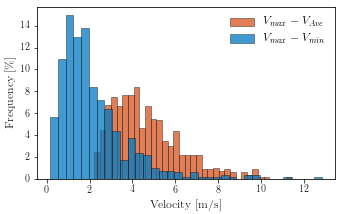

In [27]:
fig, ax = plt.subplots(figsize=(5,3))

tmp = eventDF['WS_max'] - eventDF['WS_mean']
data = tmp.values
ax.hist(data, bins=35, weights=100*np.ones(len(data))/len(data), facecolor='C2', edgecolor='k', alpha=0.75, label=r'$V_{max}- V_{Ave}$')

tmp = eventDF['WS_max'] - eventDF['WS_min']
data = tmp.values
ax.hist(data, bins=35, weights=100*np.ones(len(data))/len(data), facecolor='C1', edgecolor='k', alpha=0.75, label=r'$V_{max}- V_{min}$')

ax.set_xlabel(r'Velocity [m/s]')
ax.set_ylabel('Frequency [\%]')

ax.legend()
fig.savefig('{}/EOG_vgust_hist_alt.pdf'.format(figpath))

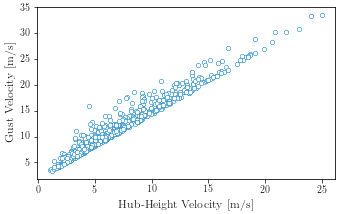

In [35]:
# velocity scatter
fig,ax,leg = extreme_event_velocity_scatter(eventDF, varcols[0:1], labels[0:1], colors=['C1'])
ax.set_ylabel('Gust Velocity [m/s]')
leg = ax.get_legend()
leg.set_visible(False)

fig.savefig('{}/EOG_vgust_scatter.pdf'.format(figpath))

In [84]:
vtmp = 8
sigma_1 = params['Iref'] * (0.75 * vtmp + 5.6)
test1 = 1.35 * (params['Ve01'] - vtmp)
test2 = 3.3 * (sigma_1 / (1 + 0.1 * params['D'] / params['Lambda_1']))

# IEC gust velocity magnitude threshold
Vgust = np.min(np.vstack([test1, test2]), axis=0)

T = 10.5 #s
t = np.linspace(0,T,101)

mod = 0.37 * Vgust * np.sin(3 * np.pi * t / T) * (1 - np.cos(2 * np.pi * t / T))

WS_pos_gustlim = vtmp - mod.min()
WS_neg_gustlim = vtmp - mod.max()

veog = vtmp-mod

fig, ax = plt.subplots(figsize=(4,2))
ax.plot(t, veog, color='C1', label=r'$V_{EOG}$')
ax.axhline(8.0, ls='--', color='k')
ax.axhline(y=veog.max(), xmin=0.35, xmax=0.65, ls='--', color='k')
ax.axhline(y=veog.min(), xmin=0.15, xmax=0.4, ls='--', color='k')
# ax.arrow(x=2.2, y=veog.min(), dx=0, dy=(8-veog.min()), color='k', width=0.025, length_includes_head=True)
# ax.arrow(x=2.2, y=8, dx=0, dy=-(8-veog.min()), color='k', width=0.025, length_includes_head=True)
# 
ax.annotate(s=r'$V_a$', xy=(0.5,0.5), xytext=(0,0), arrowprops=dict(arrowstyle='<|-|>'), xycoords='axes fraction', color='k', textcoords=(0.25,0.25))

ax.set_xlabel('Time [s]')
ax.set_ylabel(r'Velocity [m/s]')
# ax.legend()
# fig.savefig('{}/EOG_hat.pdf'.format(figpath))

Text(0,0.5,'Velocity [m/s]')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x116258268> (for post_execute):


RuntimeError: unknown coordinate type : 0.25

RuntimeError: unknown coordinate type : 0.25

In [72]:
dict(arrowstyle='<->',width=0.05)

{'arrowstyle': '<->', 'width': 0.05}

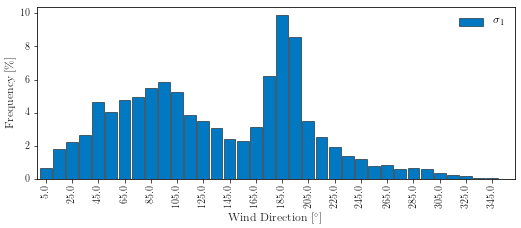

In [162]:
event_type = 'ETM'
events_files = [x for x in monthly_events_files if event_type in x]

eventDF = pd.DataFrame()
for file in events_files:
    tmp = pd.read_csv(os.path.join(datapath, file))
    eventDF = pd.concat([eventDF, tmp])
eventDF.set_index('datetime', inplace=True)
eventDF.index = pd.DatetimeIndex(eventDF.index)




binwidth = 10
eventDF['dirbin'] = pd.cut(eventDF['WD_mean'], bins=np.arange(0,360.1, binwidth), labels=np.arange(binwidth/2,360.1, binwidth))

varcols = ['sigma_1']
labels = [r'$\sigma_1$']


# ## Rose figures
# fig, ax, leg = rose_fig(eventDF, varcols[0], 'dirbin', bins=6)
# leg.set_title(labels[0])
# fig.savefig('{}/{}_{}_rose.pdf'.format(figpath, event_type, varcols[0]))


# Wind dir bar plot
fig, ax, leg = extreme_event_wind_direction_bar(eventDF, varcols[0], labels, colors='C1')
fig.savefig('{}/{}_bar.pdf'.format(figpath, event_type))

# ## Velocity scatter plot
# # adding some limitting lines here
# fig, ax, leg  = extreme_event_velocity_scatter(eventDF, varcols, labels)
# ax.plot(eventDF['WS_mean'],eventDF['sigmatest'], label='ETM limit')
# ax.set_ylabel('Turbulence Standard Deviation [m/s]'.format(labels[0]))
# leg = ax.legend()
# fig.savefig('{}/{}_v_limits.pdf'.format(figpath, event_type))

# ## monthly frequency bar plot
# fig, ax, leg  = extreme_event_monthly_bar(eventDF, varcols[0],'tmp', colors='C1')
# leg = ax.legend(labels, frameon=False)
# # ax.set_ylabel('Frequency [\%]')
# fig.savefig('{}/{}_monthly.pdf'.format(figpath, event_type))


# ## Histogram
# fig, ax, leg  = extreme_event_hist(eventDF, varcols, labels, alpha=0.75)
# ax.set_xlabel('Turbulence Standard Deviation [m/s]'.format(labels[0]))
# fig.savefig('{}/{}_hist.pdf'.format(figpath, event_type))

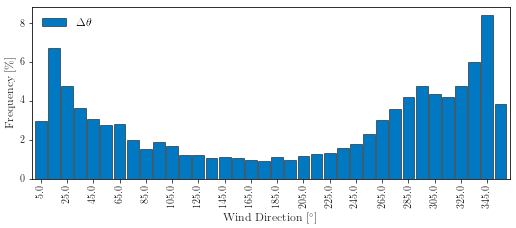

In [165]:
event_type = 'EDC'
events_files = [x for x in monthly_events_files if event_type in x]

eventDF = pd.DataFrame()
for file in events_files:
    tmp = pd.read_csv(os.path.join(datapath, file))
    eventDF = pd.concat([eventDF, tmp])
eventDF.rename(index=str, columns={'Unnamed: 0': 'datetime'}, inplace=True)
eventDF.set_index('datetime', inplace=True)
eventDF.index = pd.DatetimeIndex(eventDF.index)

# extra filtering...
eventDF[eventDF.WS_mean > 40] = np.nan
eventDF[eventDF.WS_mean < 0.1] = np.nan
eventDF.dropna(how='any', inplace=True)

# test = eventDF.copy()
eventDF = eventDF.resample('60T').last()


params = MET.setup_IEC_params()

binwidth = 10
eventDF['dirbin'] = pd.cut(eventDF['WD_mean'], bins=np.arange(0,360.1, binwidth), labels=np.arange(binwidth/2,360.1, binwidth))

varcols = ['deltaWD']
labels = [r'$\Delta \theta$']

# ## Rose figures
# fig, ax, leg = rose_fig(eventDF, varcols[0], 'dirbin', bins=6)
# leg.set_title(labels[0])
# fig.savefig('{}/{}_{}_rose.pdf'.format(figpath, event_type, varcols[0]))


# Wind dir bar plot
# fig, ax, leg = extreme_event_wind_direction_bar(eventDF, varcols[0], labels, colors='C1')
# fig.savefig('{}/{}_bar.pdf'.format(figpath, event_type))

# ## Velocity scatter plot
# # adding some limitting lines here
# fig, ax, leg  = extreme_event_velocity_scatter(eventDF, varcols, labels)
# tmp = eventDF.copy()
# binwidth = 1.0
# # Turbulence standard deviation depends on mean wind speed
# vdummy = np.linspace(0,35)
# sigma_1_e = params['Iref'] * (0.75 * vdummy + 5.6)
# # Direction change threshold depends on wind speed
# theta_e = np.degrees(4 * np.arctan( sigma_1_e / (vdummy * (1 + 0.1 * params['D'] / params['Lambda_1']))))
# # tmp['vbin'] = pd.cut(eventDF['WS_mean'], bins=np.arange(0,eventDF['WS_mean'].max(), binwidth), labels=np.arange(binwidth/2, eventDF['WS_mean'].max()-1, binwidth))
# # maxlim = tmp['delta_WD_thresh'].groupby(tmp['vbin']).min()
# ax.plot(vdummy, theta_e, color='k')
# ax.plot(vdummy, -theta_e, color='k')
# ax.set_ylim(-200,200)
# ax.set_ylabel(r'Wind Direciton Change [$^\circ$]'.format(labels[0]))
# leg = ax.legend()
# fig.savefig('{}/{}_v_limits.pdf'.format(figpath, event_type))

# ## monthly frequency bar plot
# fig, ax, leg  = extreme_event_monthly_bar(eventDF, varcols[0],'tmp', colors='C1')
# leg = ax.legend(labels, frameon=False)
# fig.savefig('{}/{}_monthly.pdf'.format(figpath, event_type))


# ## Histogram
# fig, ax, leg  = extreme_event_hist(eventDF, varcols, labels, alpha=0.75)
# ax.set_xlabel(r'Wind Direciton Change [$^\circ$]'.format(labels[0]))
# fig.savefig('{}/{}_hist.pdf'.format(figpath, event_type))

### ECD events


In [27]:
event_type = 'ECD'
events_files = [x for x in monthly_events_files if event_type in x]

eventDF = pd.DataFrame()
for file in events_files:
    tmp = pd.read_csv(os.path.join(datapath, file))
    eventDF = pd.concat([eventDF, tmp])
eventDF.drop(columns=['Unnamed: 0'], inplace=True)
eventDF.set_index('datetime', inplace=True)
eventDF.index = pd.DatetimeIndex(eventDF.index )

eventDF['deltaWD'] = np.abs(eventDF['WD_min'] - eventDF['WD_max'])
eventDF = eventDF[eventDF['deltaWD']<180]
eventDF.dropna(how='any', inplace=True)


/Users/nhamilto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [28]:
eventDF.head(1)

,WD_max,WD_mean,WD_min,WS_max,WS_mean,WS_min,WS_neg_gustlim,WS_pos_gustlim,deltaWD
datetime,,,,,,,,,
2018-03-03 07:00:00,258.832052,248.855645,239.772093,4.262391,1.871939,3.38975,1.040465,4.17067,19.059959


/Users/nhamilto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


Text(0.5,0,'Turbulence Standard Deviation, $\\Delta V_{hub}$ [m/s]')

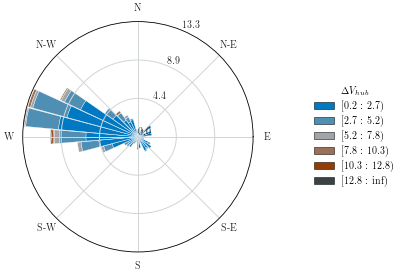

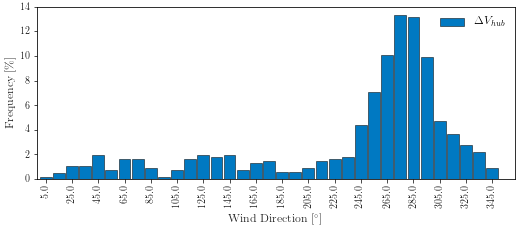

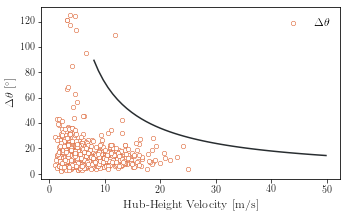

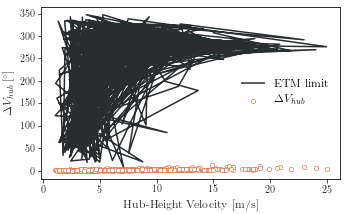

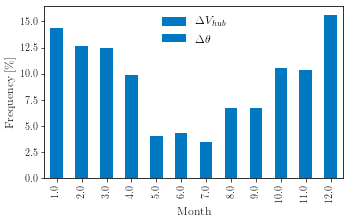

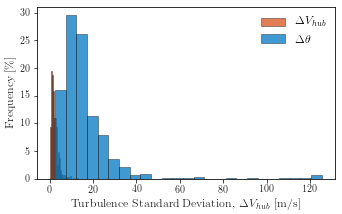

In [35]:
event_type = 'ECD'
events_files = [x for x in monthly_events_files if event_type in x]

eventDF = pd.DataFrame()
for file in events_files:
    tmp = pd.read_csv(os.path.join(datapath, file))
    eventDF = pd.concat([eventDF, tmp])
eventDF.drop(columns=['Unnamed: 0'], inplace=True)
eventDF.set_index('datetime', inplace=True)
eventDF.index = pd.DatetimeIndex(eventDF.index )

eventDF['delta_WD'] = np.abs(eventDF['WD_min'] - eventDF['WD_max'])
eventDF['delta_WS'] =eventDF['WS_max'] - eventDF['WS_min']
eventDF = eventDF[eventDF['delta_WD']<180]
eventDF.dropna(how='any', inplace=True)


binwidth = 10
eventDF['dirbin'] = pd.cut(eventDF['WD_mean'], bins=np.arange(0,360.1, binwidth), labels=np.arange(binwidth/2,360.1, binwidth))

varcols = ['delta_WS', 'delta_WD']
labels = [r'$\Delta V_{hub}$', r'$\Delta \theta$']


# ## Rose figures
fig, ax, leg = rose_fig(eventDF, varcols[0], 'dirbin', bins=6)
leg.set_title(labels[0])
# fig.savefig('{}/{}_{}_rose.pdf'.format(figpath, event_type, varcols[0]))


# Wind dir bar plot
fig, ax, leg = extreme_event_wind_direction_bar(eventDF, varcols[0], labels, colors=['C1'])
fig.savefig('{}/{}_bar.pdf'.format(figpath, event_type))

vdummy = np.linspace(8,50)
thetacg = 180 * np.ones(len(vdummy))
thetacg[vdummy > 4] = 720/vdummy

## Velocity scatter plot
# adding some limitting lines here
fig, ax, leg  = extreme_event_velocity_scatter(eventDF, ['delta_WD'], [r'$\Delta \theta$'])
ax.plot(vdummy, thetacg, label='ECD Limit')
ax.set_ylabel(r'{} [$^\circ$]'.format(labels[1]))
# leg = ax.legend()
# fig.savefig('{}/{}_v_limits.pdf'.format(figpath, event_type))

# adding some limitting lines here
fig, ax, leg  = extreme_event_velocity_scatter(eventDF, ['delta_WS'], labels)
ax.plot(eventDF['WS_mean'],eventDF['WD_mean'], label='ETM limit')
ax.set_ylabel(r'{} [$^\circ$]'.format(labels[0]))
leg = ax.legend()
# fig.savefig('{}/{}_v_limits.pdf'.format(figpath, event_type))

## monthly frequency bar plot
fig, ax, leg  = extreme_event_monthly_bar(eventDF, varcols, labels, colors=['C1'])
leg = ax.legend(labels, frameon=False)
ax.set_ylabel('Frequency [\%]')
# fig.savefig('{}/{}_monthly.pdf'.format(figpath, event_type))
# 


## Histogram
fig, ax, leg  = extreme_event_hist(eventDF, varcols, labels, alpha=0.75)
ax.set_xlabel('Turbulence Standard Deviation, {} [m/s]'.format(labels[0]))
# fig.savefig('{}/{}_hist.pdf'.format(figpath, event_type))

In [37]:
event_type = 'ECD'
events_files = [x for x in monthly_events_files if event_type in x]

eventDF = pd.DataFrame()
for file in events_files:
    tmp = pd.read_csv(os.path.join(datapath, file))
    eventDF = pd.concat([eventDF, tmp])
eventDF.set_index('datetime', inplace=True)
eventDF.index = pd.DatetimeIndex(eventDF.index)
eventDF = eventDF[eventDF['delta_WD']<180]

varcols = ['delta_WS', 'delta_WD']
labels = [r'$\Delta V_{hub}$', r'$\Delta \theta$']

data = eventDF[varcols]


In [38]:
eventDF.head(1)

,WS_min,WD_min,WS_max,WD_max,WS_mean,WD_mean,delta_WD,delta_WS
datetime,,,,,,,,
2018-03-16 20:52:00,20.992619,292.037063,25.832547,302.427103,23.626072,296.800035,30.712276,11.240624


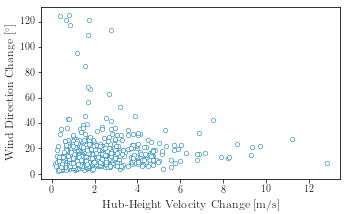

In [33]:
fig, ax = plt.subplots(figsize=(5,3))
eventDF.plot.scatter('delta_WS', 'delta_WD',  edgecolor='C1', color='w', ax=ax)
ax.set_xlabel(r'Hub-Height Velocity Change [m/s]')
ax.set_ylabel(r'Wind Direction Change [$^\circ$]')

fig.savefig('{}/{}_scatter.pdf'.format(figpath, event_type))

In [34]:
eventDF.shape

(683, 11)

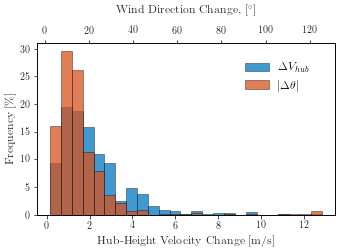

In [37]:
eventDF.dropna(how='any', inplace=True)
varcols = ['delta_WS', 'delta_WD']
labels = [r'$\Delta V_{hub}$', r'$|\Delta \theta|$']
          
fig, ax = plt.subplots(figsize=(5,3))
bins=25
alpha=0.75

data = eventDF[varcols[0]]
n,histbins,patches = ax.hist(data,
                        bins = bins,
                        facecolor='C1',
                        edgecolor='k',
                        weights=100*np.ones(data.shape) / len(data), 
                        density=False,
                        label=labels[0], alpha=alpha)
ax.set_xlabel(r'Hub-Height Velocity Change [m/s]')

ax2 = ax.twiny()
data = eventDF[varcols[1]]
n,histbins,patches = ax2.hist(data,
                        bins = bins,
                        facecolor='C2',
                        edgecolor='k',
                        weights=100*np.ones(data.shape) / len(data), 
                        density=False,
                        label=labels[1], alpha=alpha)
ax2.set_xlabel(r'Wind Direction Change, [$^\circ$]', labelpad=15)
ax.set_ylabel('Frequency [\%]')
fig.legend(loc=6, bbox_to_anchor=(0.65, 0.8))
# fig.tight_layout()

fig.savefig('{}/{}_hist.pdf'.format(figpath, event_type))

In [42]:
IEC_events = {}
event_types = ['EWS', 'EOG', 'ETM', 'EDC', 'ECD']

for event in event_types:
    
    events_files = [x for x in monthly_events_files if event in x]

    eventDF = pd.DataFrame()
    for file in events_files:
        tmp = pd.read_csv(os.path.join(datapath, file))
        eventDF = pd.concat([eventDF, tmp])
    if event is 'EDC':
        eventDF.rename(index=str, columns={'Unnamed: 0': 'datetime'}, inplace=True)
    eventDF.set_index('datetime', inplace=True)
    eventDF.index = pd.DatetimeIndex(eventDF.index)

    IEC_events[event] = eventDF.copy()
    


/Users/nhamilto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [43]:
IEC_events['EWS']['alpha_min'][IEC_events['EWS']['alpha_min'] > IEC_events['EWS']['alpha_neg_limit']] = np.nan
IEC_events['EWS']['alpha_min'][np.abs(IEC_events['EWS']['alpha_min']) > 10.0] = np.nan
IEC_events['EWS']['alpha_max'][IEC_events['EWS']['alpha_max'] < IEC_events['EWS']['alpha_pos_limit']] = np.nan
IEC_events['EWS']['alpha_max'][np.abs(IEC_events['EWS']['alpha_max']) > 10.0] = np.nan
IEC_events['EWS'] = IEC_events['EWS'].resample('10T').last()

# extra filtering...
IEC_events['EDC'][IEC_events['EDC'].WS_mean > 40] = np.nan
IEC_events['EDC'][IEC_events['EDC'].WS_mean < 0.1] = np.nan
IEC_events['EDC'].dropna(how='any', inplace=True)
IEC_events['EDC'] = IEC_events['EDC'].resample('1H').last()

IEC_events['EOG'].rename(index=str, columns={'Unnamed: 0': 'datetime'}, inplace=True)
# IEC_events['EOG'].set_index('datetime', inplace=True)
IEC_events['EOG'].index = pd.DatetimeIndex(IEC_events['EOG']['datetime'])
IEC_events['EOG'].dropna(how='any', inplace=True)

# IEC_events['EOG'] = IEC_events['EOG'].resample('10T').last()

In [50]:
monthly = {event: IEC_events[event].resample('1M').count() for event in event_types}
monthly = {event: monthly[event].WS_mean.groupby(monthly[event].index.month).mean() for event in event_types}

monthly_DF = pd.DataFrame.from_dict(monthly)#, names=event_types)

monthly_DF.sum().sum()

5156.952380952382

In [45]:
nrelcolors = utils.get_nrelcolors()

colors = utils.get_colors(5,basecolor='span')

colors = ['#0079c2', '#00A4E4', '#5E6A71', '#D9531E', '#933c06']

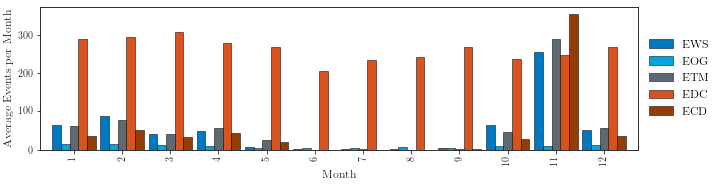

In [48]:
fig, ax = plt.subplots(figsize=(10,2.5))

monthly_DF.plot.bar(ax=ax,width=0.9, edgecolor='k', color=colors)
leg = ax.legend(loc=6, bbox_to_anchor=(1,0.5))
ax.set_xlabel('Month')
ax.set_ylabel('Average Events per Month')
fig.savefig('{}/monthly_event_bar.pdf'.format(figpath))

In [49]:
figpath

'../figs_20190121'